# Fitting a Group of Power Spectra

In this example, we will fit a group of power spectra.

## Load Python libraries

First, we will load the Python modules we need for this tutorial.

In [1]:
# Import some useful standard library modules
import os
from pathlib import Path

# Import some general scientific python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the parameterization model group object
from fooof import FOOOF,FOOOFGroup

# Import useful parameterization related utilities and plot functions
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts import plot_spectrum
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits

### Check specparam version

In [2]:
# Check which version we are using
import fooof
print(fooof.__version__)

1.0.0


## Set data path

Next, we can set the path to where the data is available.

In [5]:
# Check current directory
os.getcwd()

In [6]:
# Set the data path to load from
data_path = Path('../Data/')

## Load group PSDs

Load CSV files, including:
- `freqs.csv`, which contains a vector of frequencies
- `eopPSDs.csv`, which contains the power values for a group of power spectrum, one for each subject

In [7]:
# Load csv files containing frequency and power values
freqs = np.ravel(pd.read_csv(data_path / "freqs.csv"))                                                             
spectra = np.array(pd.read_csv(data_path / "eop.csv"))[:,1:101]  

In [8]:
# Check shapes of loaded data
print(freqs.shape)
print(spectra.shape)

(99,)
(60, 99)


## Fit power spectra

Now we can parameterize our group of power spectra!

In [10]:
# Initialize a model object for spectral parameterization, with some settings 
fg = FOOOFGroup(peak_width_limits = [1, 8], max_n_peaks = 6, min_peak_height = 0.10, verbose = False)

In [11]:
# Fit group PSDs over the 3-40 Hz range      
fg.fit(freqs, spectra, [3, 40])

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 60                             
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

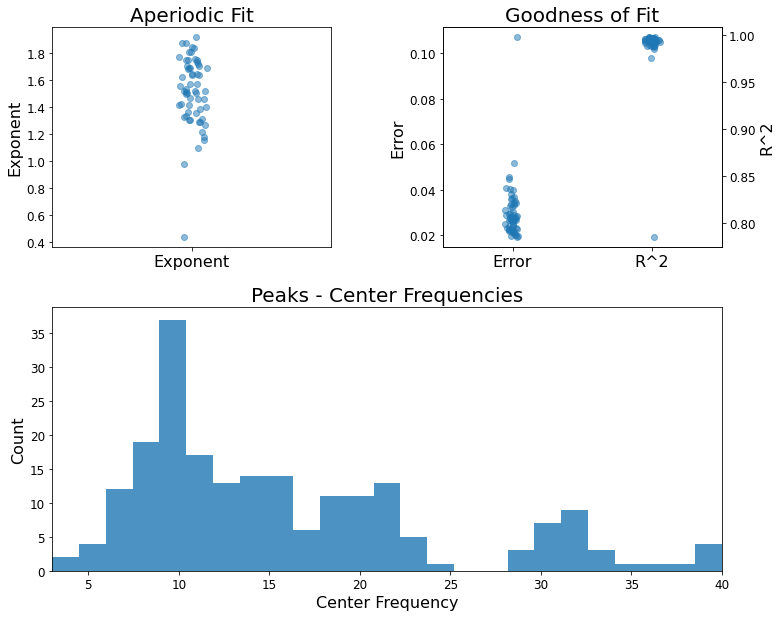

In [13]:
# Print out the group results and plots of fit parameters
fg.print_results()
fg.plot()

## Save fit information

In [14]:
# Save out a copy of the model fit report
fg.save_report('EOP_demo', file_path = '../Output')

# The following line can also be used to save out the group plot
#fg.plot(save_fig = True, file_name = "EOP_demo", file_path = '../Output')

## Extract periodic and aperiodic parameters

As with the individual model object, the `get_params` method can be used to access model fit attributes.

In addition, here we will use a `Bands` object and the `get_band_peak_fg` function to organize fit peaks into canonical band ranges.

In [16]:
# Extract aperiodic and full periodic parameters
aps = fg.get_params('aperiodic_params')
per = fg.get_params('peak_params')

In [17]:
# Extract group fit information
err = fg.get_params('error')
r2s = fg.get_params('r_squared')

In [18]:
# Check the average number of fit peaks, per model
print('Average number of fit peaks: ', np.mean(fg.n_peaks_))

Average number of fit peaks:  3.466666666666667


In [19]:
# Define canonical frequency bands 
bands = Bands({'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]})  

In [20]:
# Extract band-limited peaks information
thetas = get_band_peak_fg(fg, bands.theta)
alphas = get_band_peak_fg(fg, bands.alpha)
betas = get_band_peak_fg(fg, bands.beta)

## Plot model parameters

The specparam module also has functions for plotting the fit parameters. 

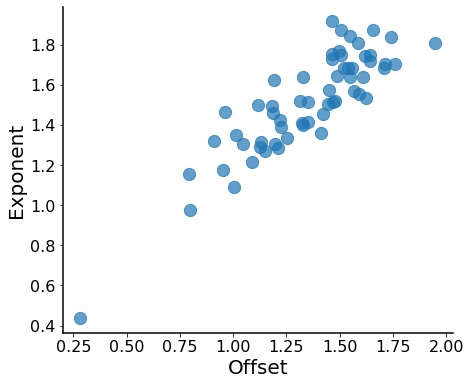

In [21]:
# Plot the measured aperiodic parameters
plot_aperiodic_params(aps)

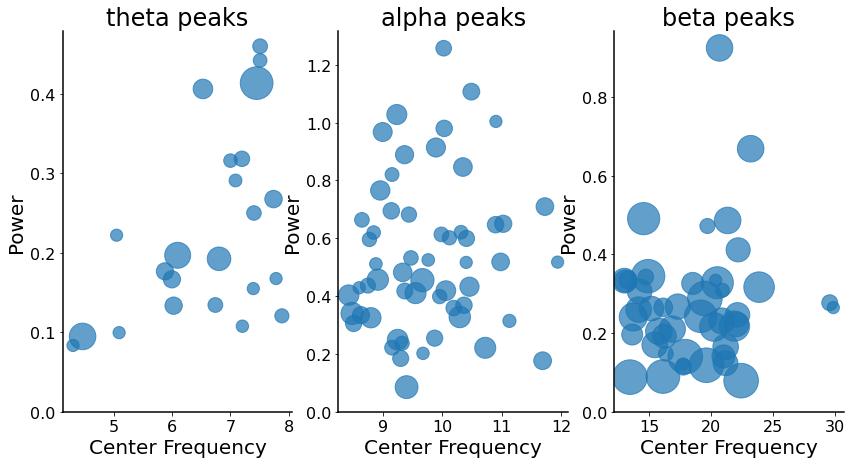

In [23]:
# Plot the parameters for peaks, split up by band
_, axes = plt.subplots(1, 3, figsize = (14, 7))
all_bands = [thetas, alphas, betas]
for ax, label, peaks in zip(np.ravel(axes), bands.labels, all_bands):
    plot_peak_params(peaks, ax=ax)
    ax.set_title(label + ' peaks', fontsize = 24)
plt.subplots_adjust(hspace = 0.4)

## Plot model components

We can also plot reconstructions of model components.

In the following, we plot reconstructed alpha peaks and aperiodic components.

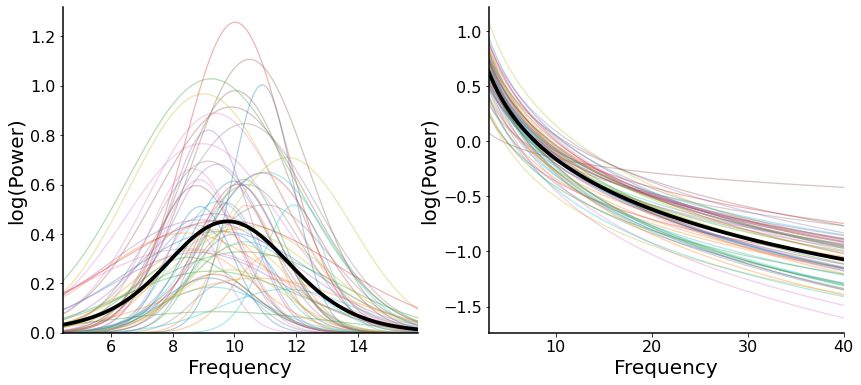

In [24]:
# Plot reconstructions of model components
_, axes = plt.subplots(1, 2, figsize = (14, 6))
plot_peak_fits(alphas, ax = axes[0])
plot_aperiodic_fits(aps, fg.freq_range, ax = axes[1])

In [ ]:
# Plot averaged fit power spectra


## Tuning the specparam algorithm 
There are no strict guidelines about optimal parameters that will be appropriate across data sets and recording modalities. We suggest applying a data-driven approach to tune model fitting for optimal performance, while taking into account your expectations about periodic and aperiodic activity given the data, the question of interest, and prior findings. 

One option is to parameterize a subset of data to evaluate the appropriateness of model fit settings prior to fitting each power spectrum in the data set. Here, we test parameters on a randomly selected 10% of the data. Results are saved out to a **Output** folder for further consideration.

In [25]:
# Create new data frame object
spectra_sub = pd.DataFrame(spectra)

# Randomly sample rows, set seed
spectra_sub = spectra_sub.sample(frac = 0.10, random_state = 1)

# Save object as array for specparam fitting
spectra_sub_array = spectra_sub.to_numpy()

In [28]:
# Create frequency vector ranging from 2-20 Hz
# NOTE: Python uses zero indexing
freq1 = freqs[2:39]

# Loop through each row to fit model for each subsample participant
for index, row in spectra_sub.iterrows():
  
  # Tidy the single PSD under consideration
  spectrum = spectra_sub.loc[[index]].transpose()[2:39]      
  spectrum = spectrum.to_numpy()
  spectrum = np.ravel(spectrum)
  
  # Initialize a model object for spectral parameterization, with some settings
  fm = FOOOF(peak_width_limits = [2, 5], max_n_peaks = 4, min_peak_height = 0.05)
  
  # Fit individual PSD over 2 to 20 Hz range
  fm.fit(freq1, spectrum, [2,20])
  
  # Save out individual results for further consideration
  fm.save_report(file_name= 'EOP_' + str(index) + '_fm1_settings', file_path= '../Output')

In [29]:
# Create frequency vector ranging from 2-20 Hz
# NOTE: Python uses zero indexing
freq2 = freqs[4:79]

# Loop through each row to fit model for each subsample participant
for index, row in spectra_sub.iterrows():
  
  # Tidy the single PSD under consideration
  spectrum = spectra_sub.loc[[index]].transpose()[4:79]      
  spectrum = spectrum.to_numpy()
  spectrum = np.ravel(spectrum)
  
  # Initialize a model object for spectral parameterization, with some settings
  fm = FOOOF(peak_width_limits = [1, 8], max_n_peaks = 6, min_peak_height = 0.10)
  
  # Fit individual PSD over 3 to 40 Hz range
  fm.fit(freq2, spectrum, [3,40])
  
  # Save out individual results for further consideration
  fm.save_report(file_name= 'EOP_' + str(index) + '_fm2_settings', file_path= '../Output')

Alternatively, you can fit the subset of data with `FOOOFGroup`, with different settings for each model object.  

In [30]:
# Initialize model objects for spectral parameterization, with some settings
fg1= FOOOFGroup(peak_width_limits= [2, 5], max_n_peaks = 4, min_peak_height = 0.05)
fg2= FOOOFGroup(peak_width_limits= [1, 8], max_n_peaks = 6, min_peak_height = 0.10)

In [31]:
# Fit group PSD over the 3-20 Hz and 3-40 Hz ranges, respectively
fg1.fit(freqs, spectra_sub_array, [3, 20])
fg2.fit(freqs, spectra_sub_array, [3, 40])

Running FOOOFGroup across 6 power spectra.
Running FOOOFGroup across 6 power spectra.


In [33]:
# Print and save subset results and plots of fit parameters, for further examination
fg1.save_report(file_name= 'EOP_' + 'fg1_settings', file_path= '../Output')
fg2.save_report(file_name= 'EOP_' + 'fg2_settings', file_path= '../Output')

/Applications/anaconda3/lib/python3.8/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
/Applications/anaconda3/lib/python3.8/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


## Check model fits
After selecting initial model fit settings, and fitting  power spectra from the full sample, it is often worthwhile to check the goodness of model fit parameters. Please note, the model objects below correspond to the model fit at the top of this script.

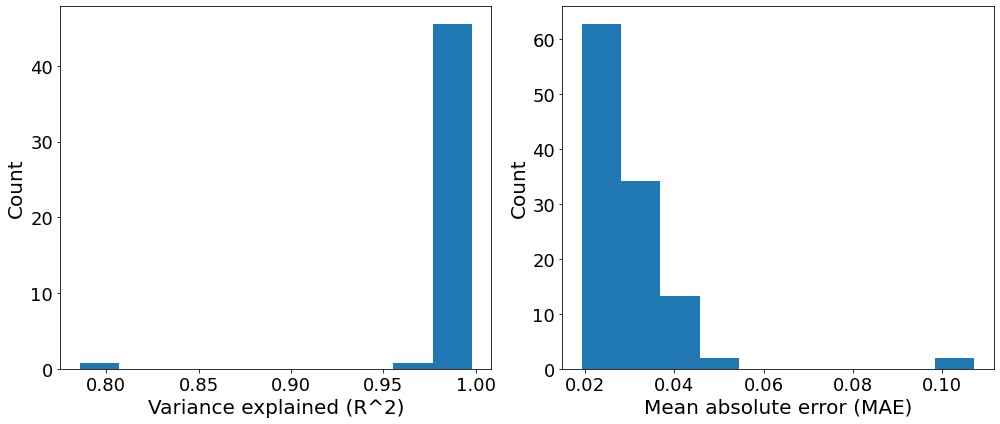

In [34]:
# Plot distributions of goodness of fit parameters
# This information is presented in the print_reports output as well
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (14, 6))

ax0.hist(r2s, density = True)
ax0.set_xlabel('Variance explained (R^2)', fontsize = 20)
ax0.set_ylabel('Count', size = 20)
ax0.tick_params(labelsize = 18)

ax1.hist(err, density = True)
ax1.set_xlabel('Mean absolute error (MAE)', fontsize = 20)
ax1.set_ylabel('Count', size = 20)
ax1.tick_params(labelsize = 18)

fig.tight_layout()
plt.show()

In [35]:
# Find the index of the worst model fit from the group
worst_fit_ind = np.argmax(fg.get_params('error'))

# Extract this model fit from the group
fm = fg.get_fooof(worst_fit_ind, regenerate = True)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.2831, 0.4376                                          
                                                                                                  
                                       1 peaks were found:                                        
          

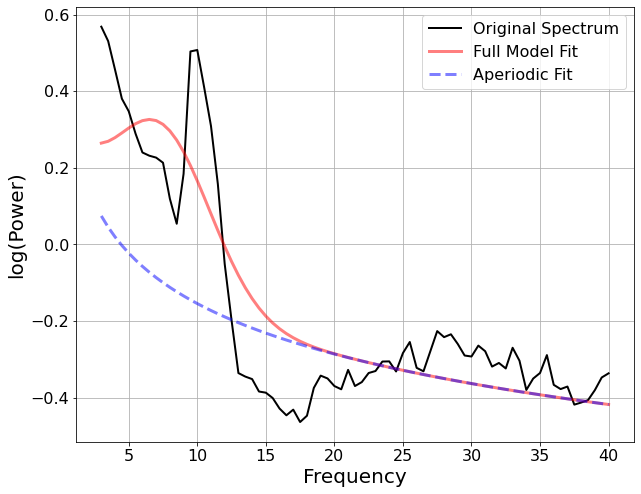

In [36]:
# Check results and visualize the extracted model
fm.print_results()
fm.plot()

### Underfitting

In [37]:
# Extract all fits that are above some error threshold, for further examination.
underfit_error_threshold = 0.100
underfit_check = []
for ind, res in enumerate(fg):
    if res.error > underfit_error_threshold:
        underfit_check.append(fg.get_fooof(ind, regenerate=True))

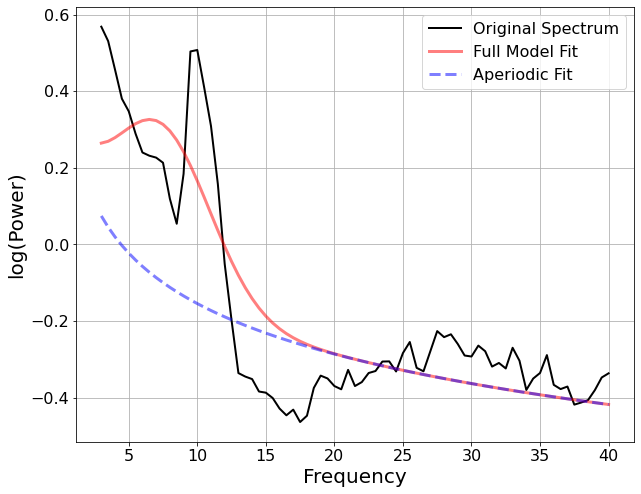

In [38]:
# Loop through the problem fits and save out reports, to check later.
for ind, fm in enumerate(underfit_check):
    fm.plot()
    fm.save_report('EOP_UnderFit_ToCheck_#' + str(ind), file_path= '../Output')

### Overfitting

In [39]:
# Extract all fits that are below some error threshold, for further examination.
overfit_error_threshold = 0.02
overfit_check = []
for ind, res in enumerate(fg):
    if res.error < overfit_error_threshold:
        overfit_check.append(fg.get_fooof(ind, regenerate=True))

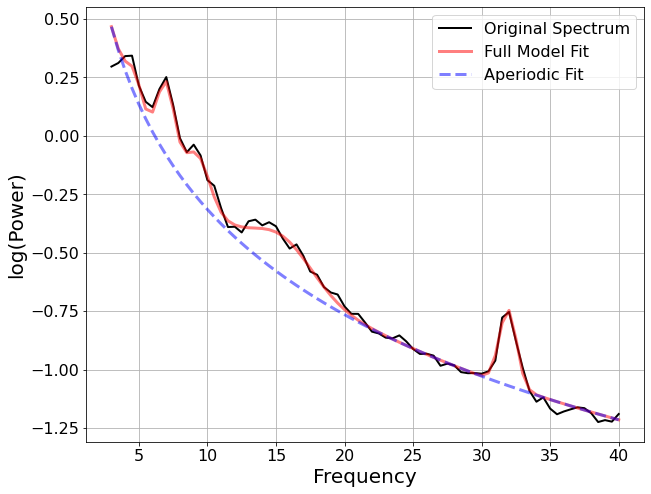

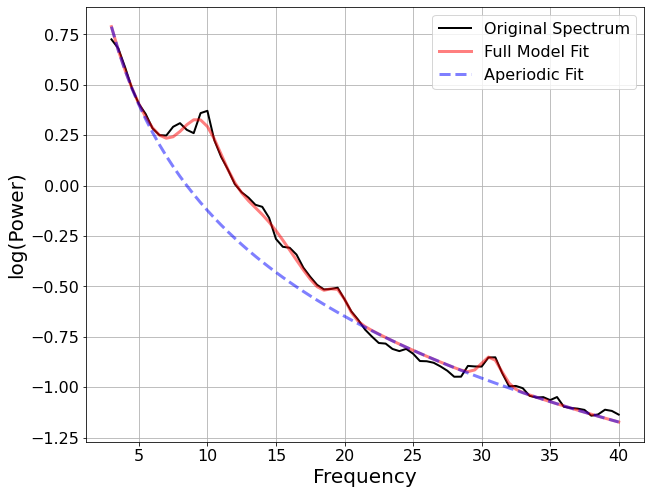

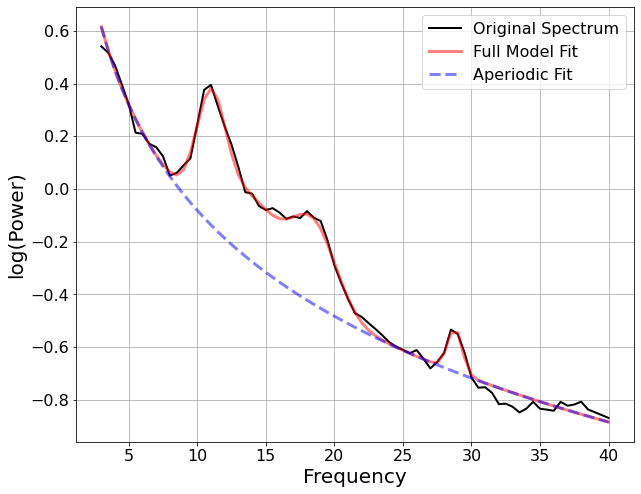

In [40]:
# Loop through the problem fits and save out reports, to check later.
for ind, fm in enumerate(overfit_check):
    fm.plot()
    fm.save_report('EOP_OverFit_ToCheck_#' + str(ind), file_path= '../Output')

## Save out data

The same approach for saving out data is available in the group object, using the `save` method. 

In [41]:
# Save out the settings used to fit the models
fg.save('group_settings', save_settings = True, file_path= '../Output')

# Save out the results of the model fits
fg.save('group_results', save_results = True, file_path= '../Output')

Another option is to save out data as a CSV file. 

In [45]:
# Save out aperiodic parameter results
aper = pd.DataFrame(aps)
aper.columns = ['offset', 'exponent']
aper.to_csv('../Output/EOP_demo_aper.csv')   

In [54]:
# Save out periodic parameter results
per = pd.DataFrame(per)
per.columns = ['CF', 'PW', 'BW']
per.to_csv('../Output/EOP_demo_per.csv')

In [55]:
# Save out model fit results
fit = pd.DataFrame([r2s, err]).transpose()
fit.columns = ['r2s', 'error']
fit.to_csv('../Output/EOP_demo_fits.csv')

### Reload Data

We can also check our saved out results by reloading them. 

In [56]:
# Reload the saved out group model results
nfg = FOOOFGroup()
nfg.load('group_results', file_path= '../Output')

In [57]:
# Check the results of the reloaded model fit
nfg.print_results()

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 60                             
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

/Applications/anaconda3/lib/python3.8/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
